## Setup and Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Import improved training functions
from improved_gan_training import (
    BaselineGAN,
    LabelSmoothingGAN,
    FeatureMatchingGAN,
    ComparisonTrainer,
)

from models.basic_gan import create_generator, create_discriminator





## Part 1: Understanding Label Smoothing

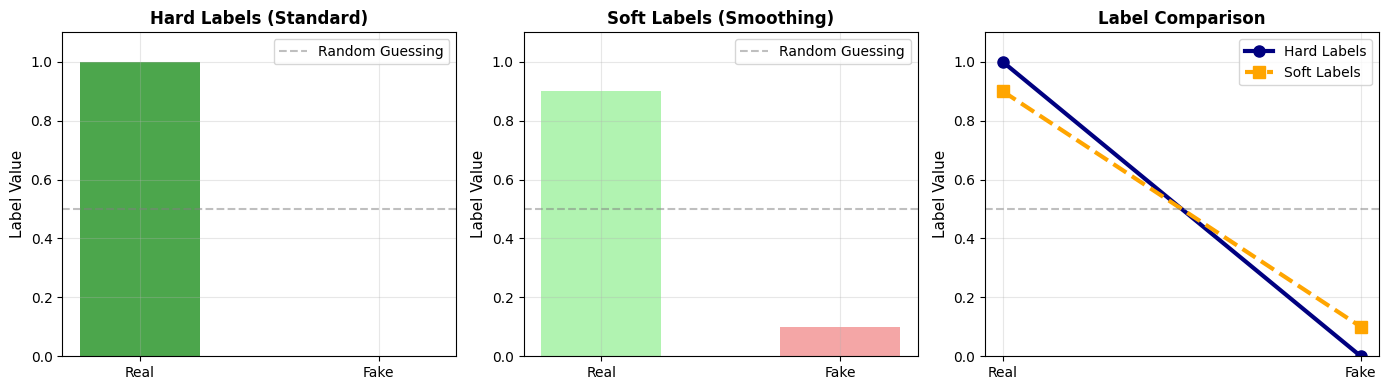


 Label Smoothing Insight:
  Hard labels (1, 0) force the discriminator to be very confident
  Soft labels (0.9, 0.1) allow the discriminator to be less confident
  This prevents the D loss from going to 0 too quickly
  Result: Generator gets stronger gradients and learns better features


In [2]:
# Visualization: Hard Labels vs Soft Labels
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Hard labels (standard)
hard_real = 1.0
hard_fake = 0.0
axes[0].bar(
    ["Real", "Fake"],
    [hard_real, hard_fake],
    color=["green", "red"],
    alpha=0.7,
    width=0.5,
)
axes[0].set_ylabel("Label Value", fontsize=11)
axes[0].set_title("Hard Labels (Standard)", fontsize=12, fontweight="bold")
axes[0].set_ylim([0, 1.1])
axes[0].axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Random Guessing")
axes[0].grid(alpha=0.3)
axes[0].legend()

# Soft labels (smoothing)
soft_real = 0.9
soft_fake = 0.1
axes[1].bar(
    ["Real", "Fake"],
    [soft_real, soft_fake],
    color=["lightgreen", "lightcoral"],
    alpha=0.7,
    width=0.5,
)
axes[1].set_ylabel("Label Value", fontsize=11)
axes[1].set_title("Soft Labels (Smoothing)", fontsize=12, fontweight="bold")
axes[1].set_ylim([0, 1.1])
axes[1].axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Random Guessing")
axes[1].grid(alpha=0.3)
axes[1].legend()

# Comparison
axes[2].plot(
    [0, 1],
    [hard_real, hard_fake],
    "o-",
    linewidth=3,
    markersize=8,
    label="Hard Labels",
    color="navy",
)
axes[2].plot(
    [0, 1],
    [soft_real, soft_fake],
    "s--",
    linewidth=3,
    markersize=8,
    label="Soft Labels",
    color="orange",
)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(["Real", "Fake"])
axes[2].set_ylabel("Label Value", fontsize=11)
axes[2].set_title("Label Comparison", fontsize=12, fontweight="bold")
axes[2].set_ylim([0, 1.1])
axes[2].axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
axes[2].grid(alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n Label Smoothing Insight:")
print("  Hard labels (1, 0) force the discriminator to be very confident")
print("  Soft labels (0.9, 0.1) allow the discriminator to be less confident")
print("  This prevents the D loss from going to 0 too quickly")
print("  Result: Generator gets stronger gradients and learns better features")


## Part 2: Understanding Feature Matching

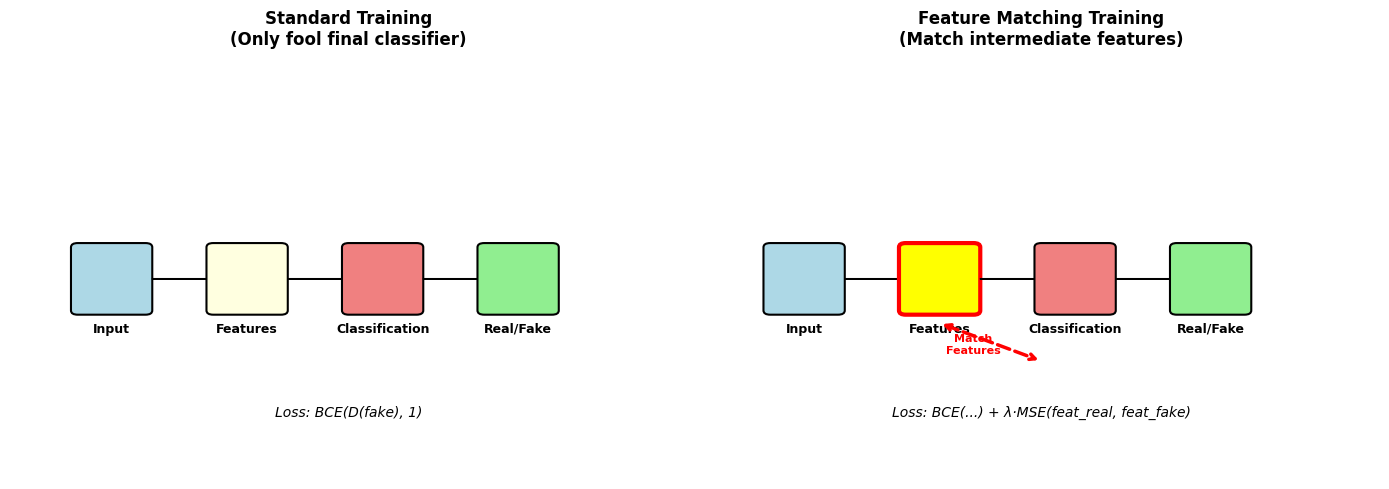


 Feature Matching Insight:
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Standard GAN: Generator only needs to fool final classifier
  Feature Matching: Generator must ALSO match intermediate features

  Benefits:
  • Forces generator to learn diverse, representative features
  • Prevents mode collapse (generator trying same trick over)
  • Improves overall sample quality
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [3]:
# Ensure matplotlib is imported
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Simplified feature matching conceptual diagram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard training
ax = axes[0]
ax.set_title(
    "Standard Training\n(Only fool final classifier)",
    fontsize=12,
    fontweight="bold",
    pad=10,
)

# Draw simple network boxes
layers_std = [
    (0.15, "Input"),
    (0.35, "Features"),
    (0.55, "Classification"),
    (0.75, "Real/Fake"),
]

colors_std = ["lightblue", "lightyellow", "lightcoral", "lightgreen"]
for i, (x, label) in enumerate(layers_std):
    rect = mpatches.FancyBboxPatch(
        (x - 0.05, 0.4),
        0.1,
        0.15,
        boxstyle="round,pad=0.01",
        edgecolor="black",
        facecolor=colors_std[i],
        linewidth=1.5,
    )
    ax.add_patch(rect)
    ax.text(x, 0.35, label, ha="center", fontsize=9, fontweight="bold")

    # Draw arrows between layers
    if i < len(layers_std) - 1:
        ax.arrow(
            x + 0.06,
            0.475,
            0.13,
            0,
            head_width=0.03,
            head_length=0.02,
            fc="black",
            ec="black",
        )

ax.text(0.5, 0.15, "Loss: BCE(D(fake), 1)", ha="center", fontsize=10, style="italic")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

# Feature matching training
ax = axes[1]
ax.set_title(
    "Feature Matching Training\n(Match intermediate features)",
    fontsize=12,
    fontweight="bold",
    pad=10,
)

# Draw network with feature extraction highlight
layers_fm = [
    (0.15, "Input"),
    (0.35, "Features"),
    (0.55, "Classification"),
    (0.75, "Real/Fake"),
]

colors_fm = ["lightblue", "yellow", "lightcoral", "lightgreen"]
for i, (x, label) in enumerate(layers_fm):
    edge_color = "red" if i == 1 else "black"
    edge_width = 3 if i == 1 else 1.5
    rect = mpatches.FancyBboxPatch(
        (x - 0.05, 0.4),
        0.1,
        0.15,
        boxstyle="round,pad=0.01",
        edgecolor=edge_color,
        facecolor=colors_fm[i],
        linewidth=edge_width,
    )
    ax.add_patch(rect)
    ax.text(x, 0.35, label, ha="center", fontsize=9, fontweight="bold")

    # Draw arrows between layers
    if i < len(layers_fm) - 1:
        ax.arrow(
            x + 0.06,
            0.475,
            0.13,
            0,
            head_width=0.03,
            head_length=0.02,
            fc="black",
            ec="black",
        )

# Add feature matching branch (feedback loop)
ax.annotate(
    "",
    xy=(0.5, 0.28),
    xytext=(0.35, 0.37),
    arrowprops=dict(arrowstyle="<->", lw=2.5, color="red", linestyle="--"),
)
ax.text(
    0.40,
    0.30,
    "Match\nFeatures",
    ha="center",
    fontsize=8,
    color="red",
    fontweight="bold",
)

ax.text(
    0.5,
    0.15,
    "Loss: BCE(...) + λ·MSE(feat_real, feat_fake)",
    ha="center",
    fontsize=10,
    style="italic",
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

plt.tight_layout()
plt.show()

print("\n Feature Matching Insight:")
print("  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print("  Standard GAN: Generator only needs to fool final classifier")
print("  Feature Matching: Generator must ALSO match intermediate features")
print("")
print("  Benefits:")
print("  • Forces generator to learn diverse, representative features")
print("  • Prevents mode collapse (generator trying same trick over)")
print("  • Improves overall sample quality")
print("  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")


## Part 3: Prepare Dataset

Using device: cuda

Loading Fashion MNIST dataset...


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.00MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 31.5MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

✓ Dataset loaded
  Total images: 60000
  Batch size: 64
  Batches per epoch: 938


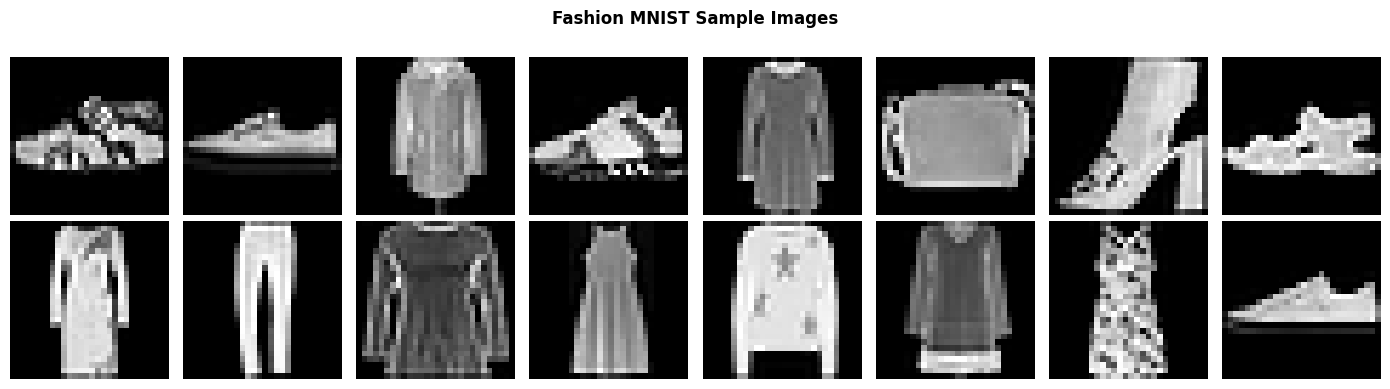

In [4]:
# Set device

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}\n")
torch.manual_seed(42)

# Load Fashion MNIST
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    ]
)

print("Loading Fashion MNIST dataset...")
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

print(f" Dataset loaded")
print(f"  Total images: {len(train_dataset)}")
print(f"  Batch size: {batch_size}")
print(f"  Batches per epoch: {len(train_loader)}")

# Show sample images
sample_batch, _ = next(iter(train_loader))
fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i in range(16):
    ax = axes[i // 8, i % 8]
    ax.imshow(sample_batch[i].squeeze().cpu(), cmap="gray")
    ax.axis("off")
plt.suptitle("Fashion MNIST Sample Images", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


## Part 4: Train Comparison Models

⏱️ **Note:** Training 3 models × 50 epochs will take 10-20 minutes depending on your device.

In [5]:
# Initialize comparison trainer
trainer = ComparisonTrainer(device=device)

# Train all variants (50 epochs each)
# This will take several minutes
results = trainer.train_all_variants(
    generator_class=create_generator,
    discriminator_class=create_discriminator,
    train_loader=train_loader,
    num_epochs=50,
    lr=0.0002,
    beta1=0.5,
)


Training Baseline GAN (No Stabilization)...
Epoch 1/50 | D Loss: 0.2185 | G Loss: 3.0130
Epoch 10/50 | D Loss: 0.4427 | G Loss: 1.7411
Epoch 20/50 | D Loss: 0.4667 | G Loss: 1.5258
Epoch 30/50 | D Loss: 0.4568 | G Loss: 1.5323
Epoch 40/50 | D Loss: 0.4517 | G Loss: 1.5512
Epoch 50/50 | D Loss: 0.4353 | G Loss: 1.6235
✓ Training complete for Baseline (No Stabilization)


Training Label Smoothing GAN (0.9/0.1)...
Epoch 1/50 | D Loss: 0.4387 | G Loss: 1.8471
Epoch 10/50 | D Loss: 0.5464 | G Loss: 1.3525
Epoch 20/50 | D Loss: 0.5501 | G Loss: 1.2861
Epoch 30/50 | D Loss: 0.5499 | G Loss: 1.2710
Epoch 40/50 | D Loss: 0.5379 | G Loss: 1.3250
Epoch 50/50 | D Loss: 0.5292 | G Loss: 1.3660
✓ Training complete for Label Smoothing (0.9/0.1)


Training Feature Matching GAN...
Epoch 1/50 | D Loss: 0.2382 | G Loss: 2.9344
Epoch 10/50 | D Loss: 0.4197 | G Loss: 1.8691
Epoch 20/50 | D Loss: 0.4575 | G Loss: 1.5905


## Part 5: Visualize Loss Curves Comparison

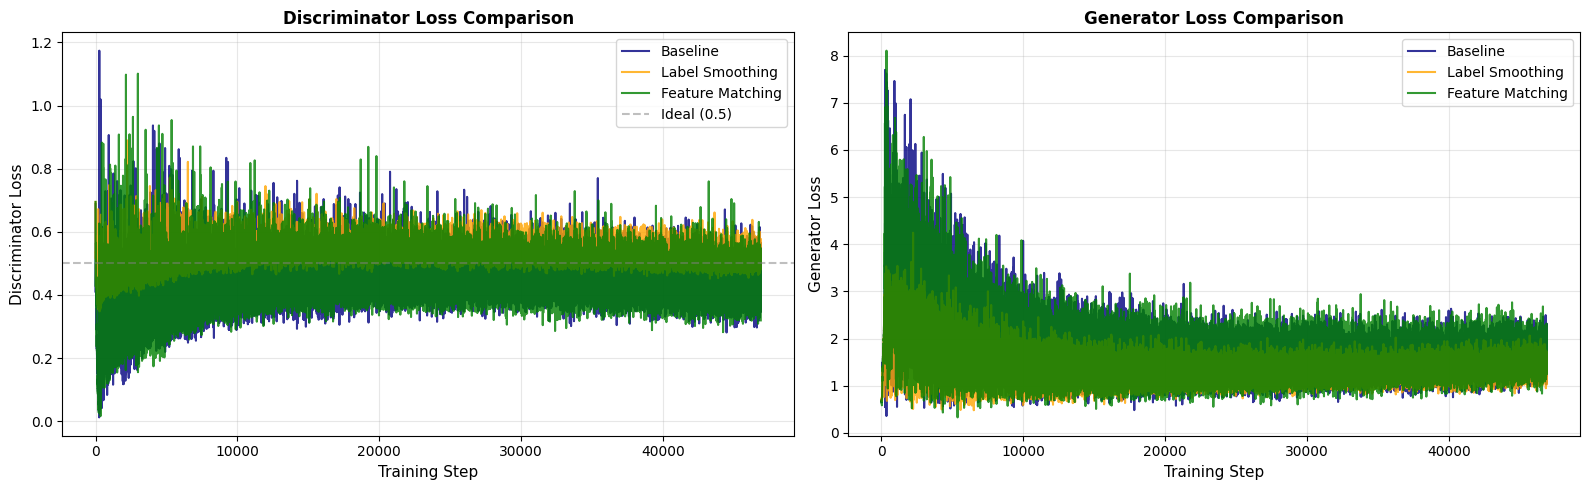

In [10]:
# Plot loss curves for all three methods
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = {"Baseline": "navy", "Label Smoothing": "orange", "Feature Matching": "green"}
alphas = {"Baseline": 0.8, "Label Smoothing": 0.8, "Feature Matching": 0.8}

# Discriminator losses
ax = axes[0]
for variant_name, losses in results.items():
    d_losses = losses["d_losses"]
    ax.plot(
        d_losses,
        label=variant_name,
        color=colors.get(variant_name, "blue"),
        alpha=alphas.get(variant_name, 0.7),
        linewidth=1.5,
    )

ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Ideal (0.5)")
ax.set_xlabel("Training Step", fontsize=11)
ax.set_ylabel("Discriminator Loss", fontsize=11)
ax.set_title("Discriminator Loss Comparison", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Generator losses
ax = axes[1]
for variant_name, losses in results.items():
    g_losses = losses["g_losses"]
    ax.plot(
        g_losses,
        label=variant_name,
        color=colors.get(variant_name, "blue"),
        alpha=alphas.get(variant_name, 0.7),
        linewidth=1.5,
    )

ax.set_xlabel("Training Step", fontsize=11)
ax.set_ylabel("Generator Loss", fontsize=11)
ax.set_title("Generator Loss Comparison", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Part 6: Stability Metrics Analysis


GAN STABILITY COMPARISON REPORT

Baseline:
  Discriminator Loss:
    Average: 0.4493
    Std Dev: 0.0537
    Oscillation: 0.066761
  Generator Loss:
    Average: 1.5989
    Std Dev: 0.2901
    Oscillation: 0.470092

Label Smoothing:
  Discriminator Loss:
    Average: 0.5271
    Std Dev: 0.0272
    Oscillation: 0.038521
  Generator Loss:
    Average: 1.3892
    Std Dev: 0.1577
    Oscillation: 0.241090

Feature Matching:
  Discriminator Loss:
    Average: 0.4384
    Std Dev: 0.0501
    Oscillation: 0.071852
  Generator Loss:
    Average: 1.6330
    Std Dev: 0.2791
    Oscillation: 0.448718

ANALYSIS:

✓ Best D Loss Stability: Label Smoothing
  Std Dev: 0.0272

✓ Best G Loss Stability: Label Smoothing
  Std Dev: 0.1577

✓ Best D Loss Balance (closest to 0.5): Label Smoothing
  Average D Loss: 0.5271



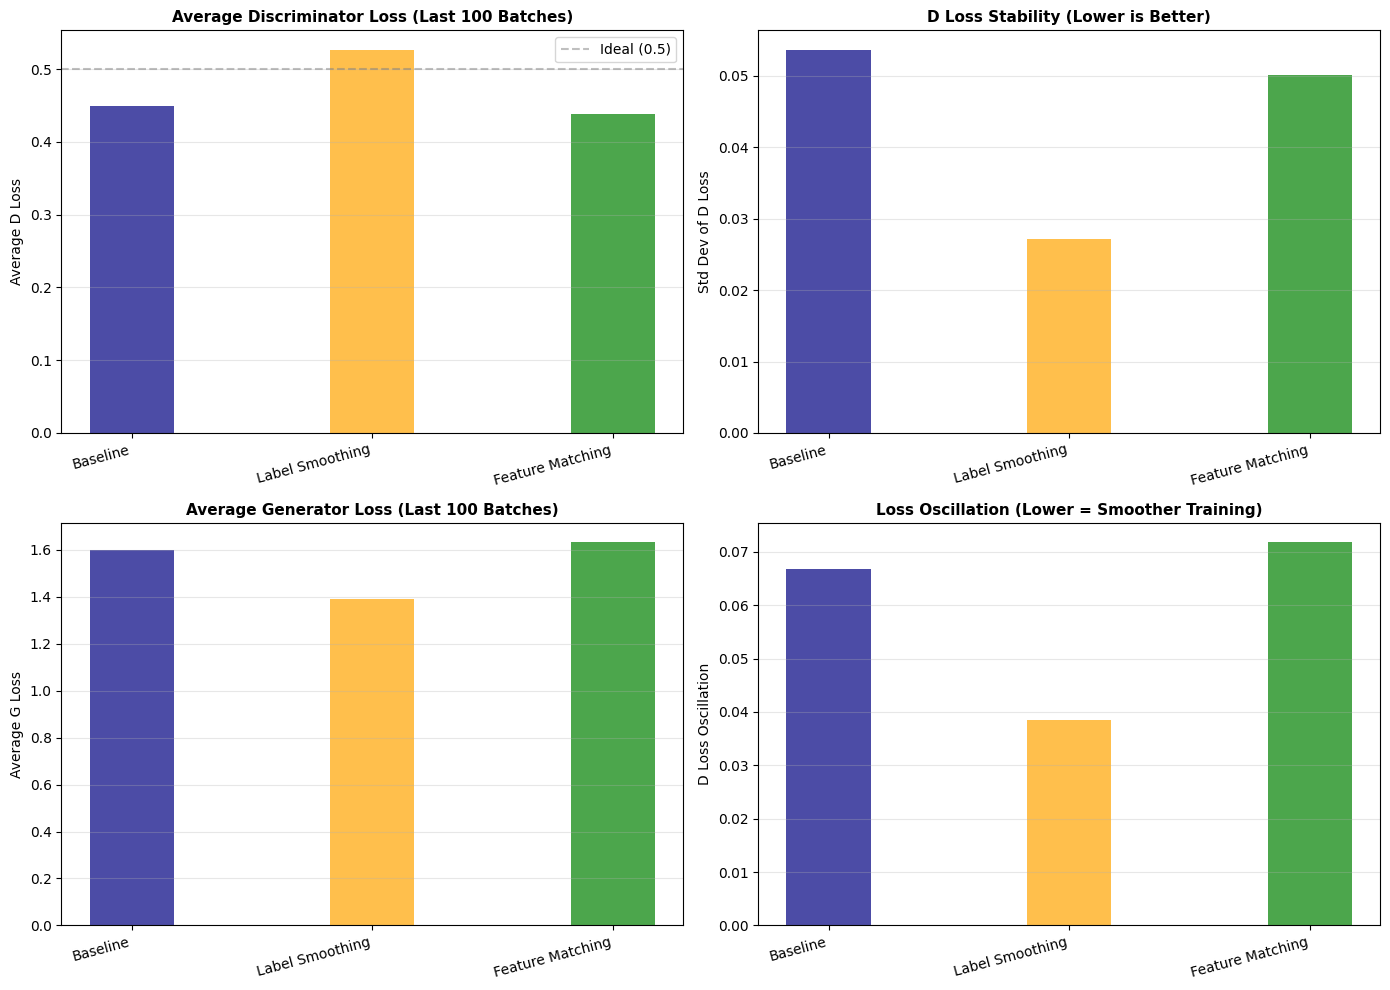

In [11]:
# Print detailed comparison report
trainer.print_comparison_report()

# Extract metrics for visualization
metrics = trainer.get_stability_metrics()

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

variants = list(metrics.keys())
x_pos = np.arange(len(variants))
width = 0.35

# Average D Loss
ax = axes[0, 0]
d_losses = [metrics[v]["avg_d_loss"] for v in variants]
ax.bar(
    x_pos,
    d_losses,
    color=[colors.get(v, "blue") for v in variants],
    alpha=0.7,
    width=width,
)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Ideal (0.5)")
ax.set_ylabel("Average D Loss", fontsize=10)
ax.set_title(
    "Average Discriminator Loss (Last 100 Batches)", fontsize=11, fontweight="bold"
)
ax.set_xticks(x_pos)
ax.set_xticklabels(variants, rotation=15, ha="right")
ax.legend()
ax.grid(alpha=0.3, axis="y")

# D Loss Stability (Std Dev)
ax = axes[0, 1]
d_stds = [metrics[v]["std_d_loss"] for v in variants]
ax.bar(
    x_pos,
    d_stds,
    color=[colors.get(v, "blue") for v in variants],
    alpha=0.7,
    width=width,
)
ax.set_ylabel("Std Dev of D Loss", fontsize=10)
ax.set_title("D Loss Stability (Lower is Better)", fontsize=11, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(variants, rotation=15, ha="right")
ax.grid(alpha=0.3, axis="y")

# Average G Loss
ax = axes[1, 0]
g_losses = [metrics[v]["avg_g_loss"] for v in variants]
ax.bar(
    x_pos,
    g_losses,
    color=[colors.get(v, "blue") for v in variants],
    alpha=0.7,
    width=width,
)
ax.set_ylabel("Average G Loss", fontsize=10)
ax.set_title(
    "Average Generator Loss (Last 100 Batches)", fontsize=11, fontweight="bold"
)
ax.set_xticks(x_pos)
ax.set_xticklabels(variants, rotation=15, ha="right")
ax.grid(alpha=0.3, axis="y")

# Loss Oscillation
ax = axes[1, 1]
d_osc = [metrics[v]["d_oscillation"] for v in variants]
ax.bar(
    x_pos,
    d_osc,
    color=[colors.get(v, "blue") for v in variants],
    alpha=0.7,
    width=width,
)
ax.set_ylabel("D Loss Oscillation", fontsize=10)
ax.set_title(
    "Loss Oscillation (Lower = Smoother Training)", fontsize=11, fontweight="bold"
)
ax.set_xticks(x_pos)
ax.set_xticklabels(variants, rotation=15, ha="right")
ax.grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()


## Summary

### What You Learned:
1. **Label Smoothing**: Simple technique that prevents discriminator overconfidence
2. **Feature Matching**: Advanced technique that prevents mode collapse
3. **How to measure stability**: Tracking loss magnitude, variance, and oscillation
4. **Empirical comparison**: Data-driven approach to choosing stabilization methods
